In [86]:
cd /Users/benrosand/oct-qiskit-pulse

/Users/benrosand/oct-qiskit-pulse
/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
import numpy as np

import qiskit
from qiskit import IBMQ, QuantumRegister, ClassicalRegister, assemble
from qiskit.extensions import UnitaryGate
from qiskit.providers.aer import PulseSimulator, Aer, QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.test.mock import FakeArmonk
from qiskit.tools import job_monitor
from src.helper import qutip_ham_converter
from src.qoc_instruction_schedule_map import QOCInstructionScheduleMap
from src.qutip_optimizer import qutip_optimizer

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
real_armonk_backend = provider.get_backend('ibmq_armonk')
fake_armonk_backend = FakeArmonk()

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
ibmqfactory.load_account:WARNING:2020-08-31 15:19:50,210: Credentials are already in use. The existing account in the session will be replaced.


In [89]:
#set armonk sim parameters
# omegad0 = 31919806.545849085
omegad0 = real_armonk_backend.configuration().hamiltonian['vars']['omegad0']

# omegad0 = 0.07
getattr(fake_armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = omegad0
freq_est = real_armonk_backend.defaults().qubit_freq_est[0]/1e9
fake_armonk_backend.configuration().qubit_freq_est=[freq_est]
getattr(fake_armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est
fake_armonk_model = PulseSystemModel.from_backend(fake_armonk_backend)

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
# Instantiate grape optimizer with armonk backend
grape_optimizer = qutip_optimizer(fake_armonk_backend, n_ts=320)

# Create new QOCInstructionScheduleMap with this optimizer
def_inst = ['measure']
builtin_instructions = fake_armonk_backend.defaults().instruction_schedule_map
grape_inst_map = QOCInstructionScheduleMap.from_inst_map(grape_optimizer, builtin_instructions,
                                                         default_inst=def_inst)


/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
# choose random phi for u3 rotation
phi = np.random.random_sample(1)
theta = np.random.random_sample(1)
lamb = np.random.random_sample(1)
phi = phi[0] * np.pi
phi = np.pi

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
# create circuit
q = QuantumRegister(1)
c = ClassicalRegister(1)
circ = qiskit.QuantumCircuit(q, c)
# add an x gate using u3
# circ.x(q)
# circ.h(q)
circ.u3(phi,0,phi, q)
# circ.u3(theta,phi,lamb, q)
# add measurement pulse
circ.measure([0],[0])

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
# construct the schedule from the circuit using the grape instruction_schedule_map
grape_schedule = qiskit.schedule(circ, inst_map = grape_inst_map,
                        meas_map = fake_armonk_backend.configuration().meas_map)

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
gate hit
/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/qiskit/pulse/library/sample_pulse.py:42: DeprecationWarning: SamplePulse has been renamed to Waveform and is deprecated. Please replace SamplePulse(samples, channel) with Waveform(samples, channel).
  warnings.warn("SamplePulse has been renamed to Waveform and is deprecated. " +


In [94]:
# now compare to the default
default_schedule = qiskit.schedule(circ, inst_map = builtin_instructions,
                        meas_map = fake_armonk_backend.configuration().meas_map)

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
grape_schedule.duration
default_schedule.duration

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


17280

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


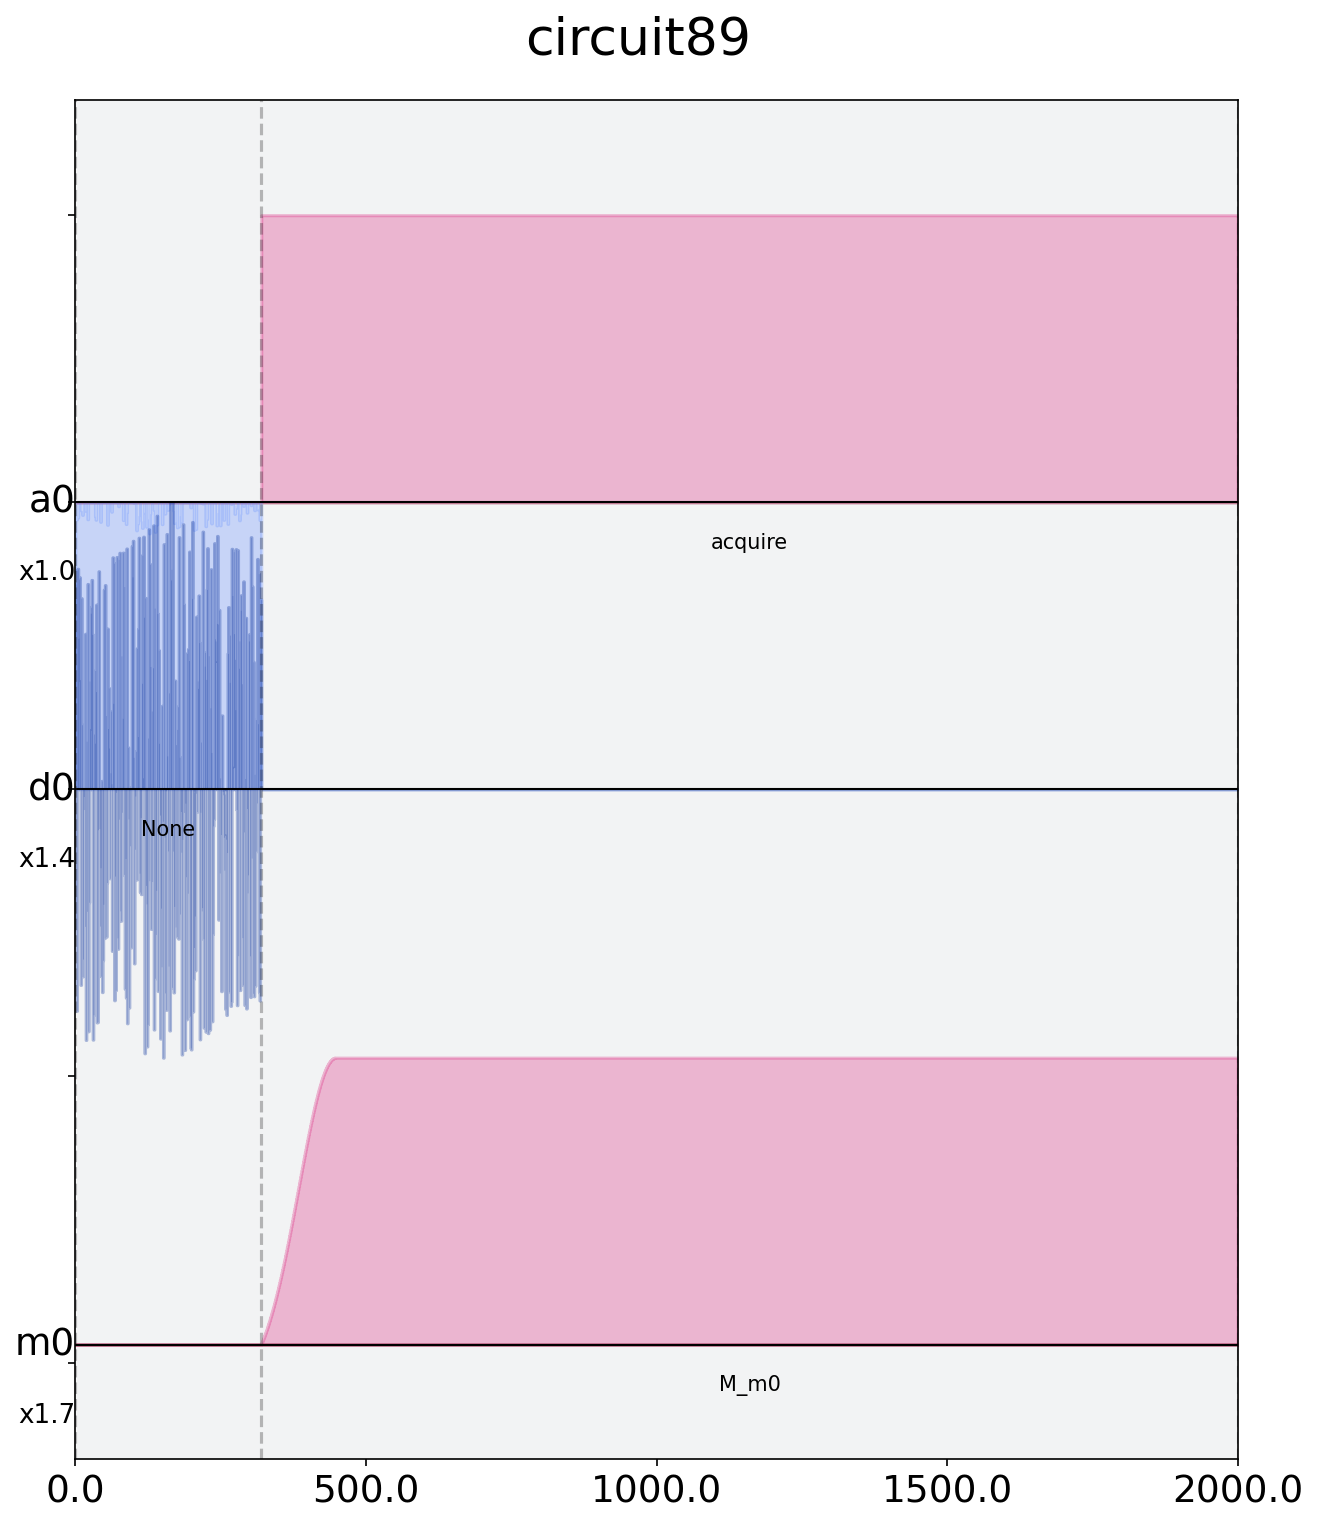

In [96]:
grape_schedule.draw(plot_range=[0,2000], label=True)

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


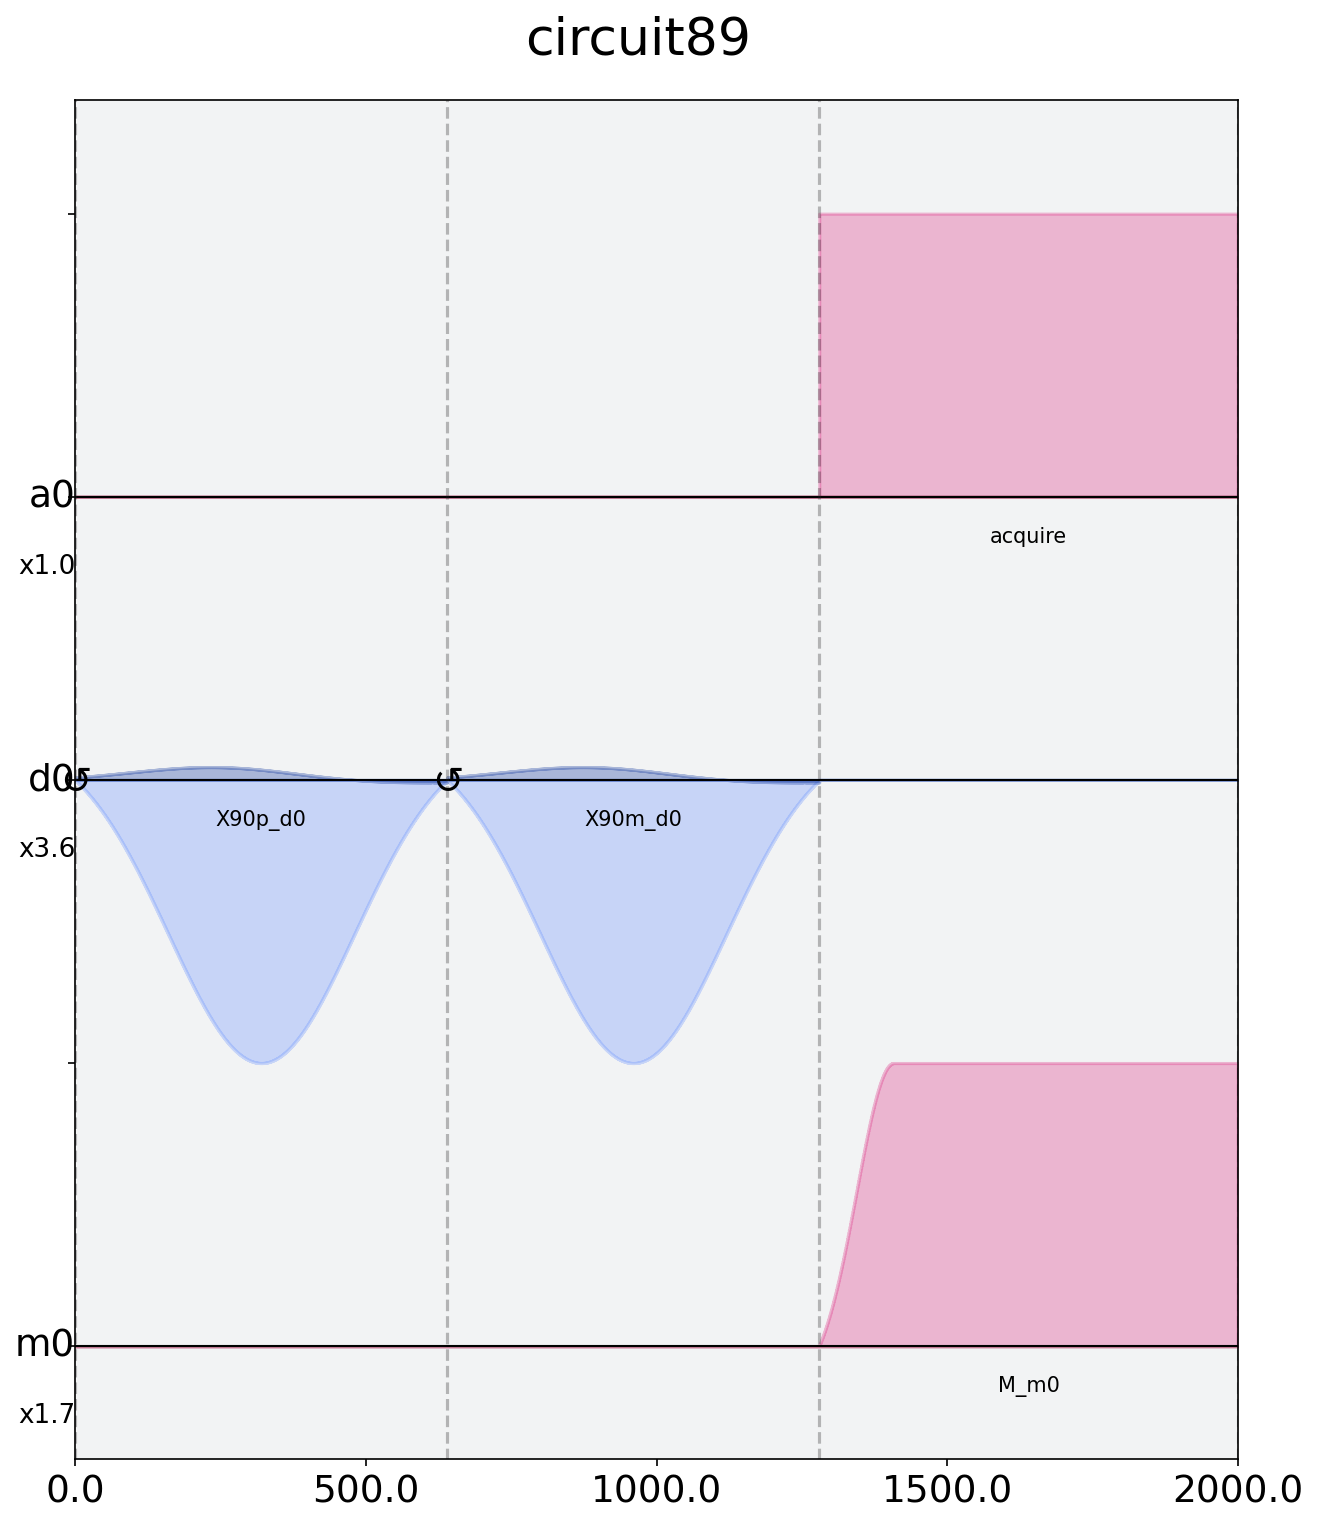

In [97]:
default_schedule.draw(plot_range=[0,2000], label=True)
# grape_schedule.draw(label=True, scaling=0.8)

In [98]:
# assemble qobj for job submission
backend_sim = PulseSimulator(configuration=fake_armonk_backend.configuration)

grape_qobj = assemble(grape_schedule,
                      backend=backend_sim,
                      qubit_lo_freq=[freq_est],
                      meas_level=2,
                      meas_return='single',
                      shots=1024)

default_qobj = assemble(default_schedule,
                      backend=backend_sim,
                      qubit_lo_freq=[freq_est],
                      meas_level=2,
                      meas_return='single',
                      shots=1024)

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
sim_result = backend_sim.run(grape_qobj, fake_armonk_model).result()
def_sim_result = backend_sim.run(default_qobj, fake_armonk_model).result()
# sim_result.get_counts()

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
noise_model = NoiseModel()
noise_model.add_basis_gates(['unitary'])
ideal_job = qiskit.execute(circ, QasmSimulator(),
                           basis_gates=noise_model.basis_gates)
# ideal_job.result().get_counts()



/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
num_shots = 1024

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [102]:
armonk_qobj = assemble(grape_schedule,
                      backend=real_armonk_backend,
                      qubit_lo_freq=[freq_est*1e9],
                      meas_level=2,
                      meas_return='single',
                      shots=num_shots)
real_job = real_armonk_backend.run(armonk_qobj)
job_id = real_job._job_id

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
def_armonk_qobj = assemble(default_schedule,
                      backend=real_armonk_backend,
                      qubit_lo_freq=[freq_est*1e9],
                      meas_level=2,
                      meas_return='single',
                      shots=num_shots)
def_real_job = real_armonk_backend.run(def_armonk_qobj)
def_job_id = def_real_job._job_id

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:

def_job = real_armonk_backend.retrieve_job(def_job_id)
job_monitor(def_job)
# def_job.result().get_counts()

job = real_armonk_backend.retrieve_job(job_id)
job_monitor(job)
# job.result().get_counts()

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Job Status: job has successfully run
Job Status: job has successfully run


In [105]:
speedup = (default_schedule.duration - 16000) / (grape_schedule.duration - 16000)
def_acc = def_real_job.result().get_counts()['1'] / num_shots
grape_acc = real_job.result().get_counts()['1'] / num_shots
print('ideal (perfect gate) results: {}'.format(ideal_job.result().get_counts()))
print('simulated results (grape pulse): {}'.format(sim_result.get_counts()))
print('simulated results (builtin pulse): {}'.format(def_sim_result.get_counts()))
print('grape gate speedup factor: {}'.format(speedup))
print('hardware results (grape): {}'.format(real_job.result().get_counts()))
print('hardware results (default): {}'.format(def_real_job.result().get_counts()))
print('grape acc: {}, default acc: {}'.format(grape_acc, def_acc))
# print('Grape run on {} backend'.format(which_armonk))
# print('Used grape gate: {}'.format(not def_x))

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
ideal (perfect gate) results: {'1': 1024}
simulated results (grape pulse): {'0': 1024}
simulated results (builtin pulse): {'0': 1024}
grape gate speedup factor: 4.0
hardware results (grape): {'0': 107, '1': 917}
hardware results (default): {'0': 91, '1': 933}
grape acc: 0.8955078125, default acc: 0.9111328125


In [106]:
default_schedule.duration

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


17280